In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.ops import FeaturePyramidNetwork
import timm
import numpy as np
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import mean_absolute_error, mean_squared_error 

In [8]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionModule, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention_map = self.conv(torch.cat([avg_out, max_out], dim=1))
        return x * self.sigmoid(attention_map)

class DilatedDecoder(nn.Module):
    def __init__(self, in_channels, decoder_channels):
        super(DilatedDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, decoder_channels[0], 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(decoder_channels[0], decoder_channels[1], 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(decoder_channels[1], decoder_channels[2], 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(decoder_channels[2], 1, 1) )
    def forward(self, x):
        return self.decoder(x)

class DA_Net(nn.Module):
    def __init__(self, backbone_name='efficientnet_b4', pretrained=True):
        super(DA_Net, self).__init__()
        self.backbone = timm.create_model(backbone_name,pretrained=pretrained, features_only=True, out_indices=(1, 2, 3) )
        self.backbone.feature_info.out_indices = (1, 2, 3) 
        backbone_channels = self.backbone.feature_info.channels() 
        fpn_out_channels = 256
        self.fpn = FeaturePyramidNetwork(in_channels_list=backbone_channels,  out_channels=fpn_out_channels,)
        self.attention = SpatialAttentionModule()
        self.decoder = DilatedDecoder(in_channels=fpn_out_channels, decoder_channels=[128, 64, 32])

    def forward(self, x):
        features = self.backbone(x) 
        fpn_input = OrderedDict()
        for i, feature_map in enumerate(features):
            fpn_input[f'{i}'] = feature_map 

        fpn_features = self.fpn(fpn_input)
        fpn_highest_res_output = fpn_features['0']
        attention_features = self.attention(fpn_highest_res_output)
        density_map_raw = self.decoder(attention_features) 
        density_map = F.relu(density_map_raw)
        return density_map


def get_my_model(model_name='DA_Net', pretrained_backbone=False):
    if model_name == 'DA_Net':
        model = DA_Net(backbone_name='efficientnet_b5', pretrained=pretrained_backbone)
    else:
        raise ValueError(f"Unknown model name")
    return model

class CrowdCountingDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_transform=None, image_target_size=(256, 256), density_target_size=(128, 128)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted(glob.glob(os.path.join(image_dir, "*.jpg"))) 
        self.label_files = [
            os.path.join(label_dir, os.path.basename(f).replace('.jpg', '.npy'))
            for f in self.image_files
        ]
        valid_indices = [i for i, lf in enumerate(self.label_files) if os.path.exists(lf)]
        self.image_files = [self.image_files[i] for i in valid_indices]
        self.label_files = [self.label_files[i] for i in valid_indices]
        self.image_transform = image_transform
        self.image_target_size = image_target_size
        self.density_target_size = density_target_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label_path = self.label_files[idx]
        image = Image.open(image_path).convert("RGB")
        image = image.resize(self.image_target_size, Image.BILINEAR)

        if self.image_transform:
            image_tensor = self.image_transform(image) 
        else:
            image_tensor = T.ToTensor()(image) 
   
        density_np = np.load(label_path).astype(np.float32)
        original_sum = np.sum(density_np)
        density_pil = Image.fromarray(density_np)
        density_resized_pil = density_pil.resize((self.density_target_size[1], self.density_target_size[0]), Image.BILINEAR) # BILINEAR is float-friendly
        density_resized_np = np.array(density_resized_pil)

        resized_sum = np.sum(density_resized_np)
        if resized_sum > 1e-6: 
             density_resized_np = density_resized_np * (original_sum / resized_sum)
        elif original_sum > 1e-6:
             density_resized_np = density_resized_np * (original_sum / (resized_sum + 1e-9))
        density_tensor = torch.from_numpy(density_resized_np).unsqueeze(0) 
        return image_tensor, density_tensor, image_path

def denormalize_for_plot(tensor_image):
    img = tensor_image.clone().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0)
    img = torch.clamp(img, 0, 1)
    return img.numpy()


In [9]:
TEST_IMG_DIR = "/kaggle/input/dataset-crowd/processed_data/test/images" # processed test data(images) path
TEST_LBL_DIR = "/kaggle/input/dataset-crowd/processed_data/test/density_maps" # processed test data(density maps) path
MODEL_PATH = '/kaggle/input/da_net_model.pth' #Saved Model path
OUTPUT_DIR = './analysis_results' # results path

IMAGE_INPUT_SIZE = (256, 256) 
DENSITY_MAP_GT_SIZE = (128, 128) 
BATCH_SIZE = 8 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

os.makedirs(OUTPUT_DIR, exist_ok=True)
image_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = get_my_model(model_name='DA_Net', pretrained_backbone=False).to(DEVICE)
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("Model state dict loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}")
    exit() 
    
model.eval() 

test_dataset = CrowdCountingDataset(
    TEST_IMG_DIR, TEST_LBL_DIR,
    image_transform=image_transforms,
    image_target_size=IMAGE_INPUT_SIZE,
    density_target_size=DENSITY_MAP_GT_SIZE,
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if DEVICE.type == 'cuda' else False)

print("Running inference on test set...")
all_gt_counts = []
all_pred_counts = []

Using device: cpu
Model state dict loaded successfully.
Running inference on test set...


Processed batch 10/40
Processed batch 20/40
Processed batch 30/40
Processed batch 40/40
Inference complete.
Overall MAE: 20.99
Overall MSE: 1179.84
Overall RMSE: 34.35
Metrics saved to ./analysis_results/evaluation_metrics.txt

Generating Count Scatter Plot...
Count scatter plot saved to ./analysis_results/count_scatter_plot.png
Generating Error Distribution Histogram...
Error histogram saved to ./analysis_results/absolute_error_histogram.png
Generating example density map plots for 20 images...
  Plotting example 1/20 (IMG_1.jpg)
    GT Count: 23.00, Pred Count: 12.61, Error: 10.39
  Plotting example 2/20 (IMG_10.jpg)
    GT Count: 181.00, Pred Count: 194.94, Error: 13.94
  Plotting example 3/20 (IMG_100.jpg)
    GT Count: 157.00, Pred Count: 169.70, Error: 12.70
  Plotting example 4/20 (IMG_101.jpg)
    GT Count: 37.00, Pred Count: 38.43, Error: 1.43
  Plotting example 5/20 (IMG_102.jpg)
    GT Count: 70.00, Pred Count: 69.72, Error: 0.28
  Plotting example 6/20 (IMG_103.jpg)
    GT 

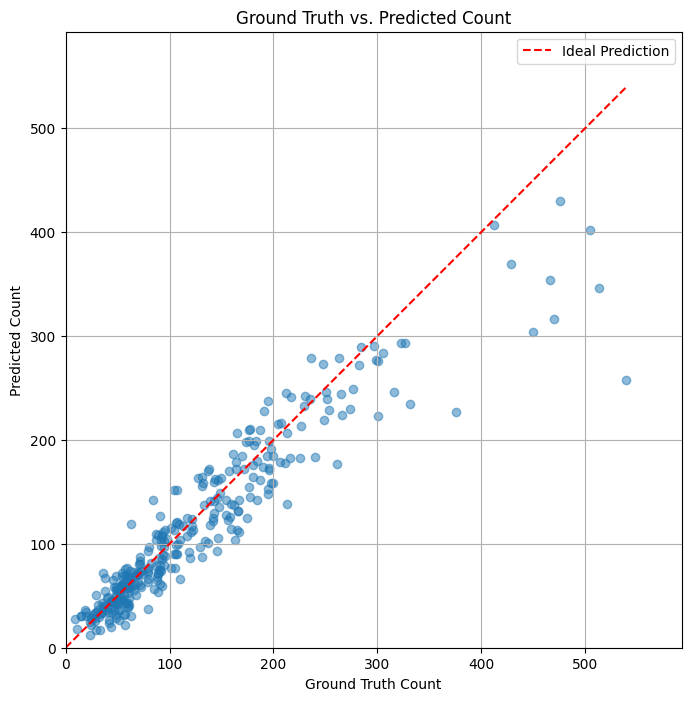

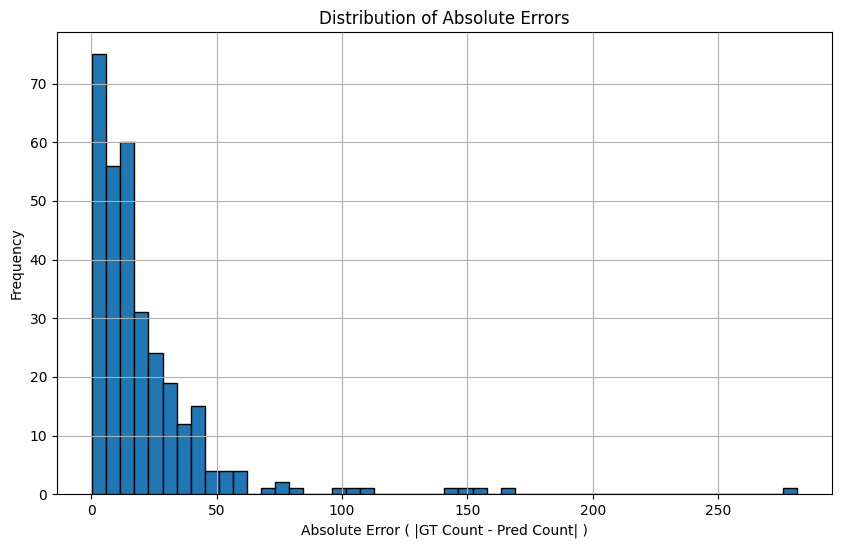

In [10]:
images_for_plot = []
gt_density_for_plot = []
pred_density_for_plot = []
image_paths_for_plot = []
num_examples_to_collect = 20

with torch.no_grad():
    for batch_idx, (images_batch, gt_density_maps_batch, image_paths) in enumerate(test_loader):
        images_batch_device = images_batch.to(DEVICE)
        pred_density_maps_raw_batch = model(images_batch_device)
        if pred_density_maps_raw_batch.shape[2:] != DENSITY_MAP_GT_SIZE:
            pred_density_maps_upsampled_batch = F.interpolate(
                pred_density_maps_raw_batch,
                size=DENSITY_MAP_GT_SIZE,
                mode='bilinear',
                align_corners=False 
            )
        else:
            pred_density_maps_upsampled_batch = pred_density_maps_raw_batch

        batch_gt_counts = torch.sum(gt_density_maps_batch, dim=(1, 2, 3)) 
        batch_pred_counts = torch.sum(pred_density_maps_upsampled_batch, dim=(1, 2, 3)).cpu() 

        all_gt_counts.extend(batch_gt_counts.numpy())
        all_pred_counts.extend(batch_pred_counts.numpy())
        if len(images_for_plot) < num_examples_to_collect:
             num_to_add = min(images_batch.size(0), num_examples_to_collect - len(images_for_plot))
             images_for_plot.extend([images_batch[i] for i in range(num_to_add)])
             gt_density_for_plot.extend([gt_density_maps_batch[i].squeeze() for i in range(num_to_add)]) 
             pred_density_for_plot.extend([pred_density_maps_upsampled_batch[i].cpu().squeeze() for i in range(num_to_add)]) 
             image_paths_for_plot.extend([image_paths[i] for i in range(num_to_add)])

        if (batch_idx + 1) % 10 == 0:
             print(f"Processed batch {batch_idx+1}/{len(test_loader)}")
print("Inference complete.")

all_gt_counts = np.array(all_gt_counts)
all_pred_counts = np.array(all_pred_counts)
mae = mean_absolute_error(all_gt_counts, all_pred_counts)
mse = mean_squared_error(all_gt_counts, all_pred_counts)
rmse = np.sqrt(mse)

print(f"Overall MAE: {mae:.2f}")
print(f"Overall MSE: {mse:.2f}")
print(f"Overall RMSE: {rmse:.2f}")

metrics_file = os.path.join(OUTPUT_DIR, 'evaluation_metrics.txt')
with open(metrics_file, 'w') as f:
    f.write("--- Crowd Counting Model Evaluation Metrics ---\n")
    f.write(f"Model: DA-Net (efficientnet_b5 backbone)\n")
    f.write(f"Test Dataset: {TEST_IMG_DIR}\n")
    f.write(f"Number of test images: {len(test_dataset)}\n")
    f.write("-" * 30 + "\n")
    f.write(f"Overall MAE: {mae:.2f}\n")
    f.write(f"Overall MSE: {mse:.2f}\n")
    f.write(f"Overall RMSE: {rmse:.2f}\n")
    f.write("-" * 30 + "\n")
print(f"Metrics saved to {metrics_file}")

print("\nGenerating Count Scatter Plot")
plt.figure(figsize=(10, 8))
plt.scatter(all_gt_counts, all_pred_counts, alpha=0.5)
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("Ground Truth vs. Predicted Count")
max_count = max(np.max(all_gt_counts), np.max(all_pred_counts))
plt.plot([0, max_count], [0, max_count], 'r--', label='Ideal Prediction')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box') 
plt.xlim(0, max_count * 1.1) 
plt.ylim(0, max_count * 1.1)
scatter_plot_path = os.path.join(OUTPUT_DIR, 'count_scatter_plot.png')
plt.savefig(scatter_plot_path)
print(f"Count scatter plot saved to {scatter_plot_path}")

print("Generating Error Distribution Histogram")
abs_errors = np.abs(all_gt_counts - all_pred_counts)
plt.figure(figsize=(10, 6))
plt.hist(abs_errors, bins=50, edgecolor='black')
plt.xlabel("Absolute Error ( |GT Count - Pred Count| )")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Errors")
plt.grid(True)
error_hist_path = os.path.join(OUTPUT_DIR, 'absolute_error_histogram.png')
plt.savefig(error_hist_path)
print(f"Error histogram saved to {error_hist_path}")
print(f"Generating example density map plots for {len(images_for_plot)} images...")

for i in range(len(images_for_plot)):
    img = denormalize_for_plot(images_for_plot[i])
    gt_density = gt_density_for_plot[i].numpy() 
    pred_density = pred_density_for_plot[i].numpy() 
    gt_count_plot = np.sum(gt_density)
    pred_count_plot = np.sum(pred_density)
    image_filename = os.path.basename(image_paths_for_plot[i])

    print(f"  Plotting example {i + 1}/{len(images_for_plot)} ({image_filename})")
    print(f"    GT Count: {gt_count_plot:.2f}, Pred Count: {pred_count_plot:.2f}, Error: {abs(gt_count_plot - pred_count_plot):.2f}")
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Input Image\n{image_filename}")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    vmax = max(np.max(gt_density), np.max(pred_density)) if np.max(gt_density) > 1e-6 else None 
    plt.imshow(gt_density, cmap='jet', vmax=vmax)
    plt.title(f"GT Density Map\nCount: {gt_count_plot:.2f}")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(pred_density, cmap='jet', vmax=vmax)
    plt.title(f"Predicted Density Map\nCount: {pred_count_plot:.2f}\nError: {abs(gt_count_plot - pred_count_plot):.2f}")
    plt.axis("off")
    plt.tight_layout()
    example_plot_path = os.path.join(OUTPUT_DIR, f'example_plot_{i+1}_{os.path.splitext(image_filename)[0]}.png')
    plt.savefig(example_plot_path)
    plt.close() 

print("\nAnalysis complete Results saved in", OUTPUT_DIR)


In [11]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [12]:
zip_dir()

/kaggle/working/directory.zip